# Julia Set

Modified version from [Loic Gouarin](https://github.com/gouarin/GTSage2014/)

[Julia set on wikipedia](https://en.wikipedia.org/wiki/Julia_set)

In [226]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.rcParams['figure.figsize'] = (6,6)

In [227]:
nx, ny = 256, 256 # mesh
lim, maxit = 400, 2000 # limits 
vmin, vmax = 0, 200 

x = np.linspace(-1.6, 1.6, nx)
y = np.linspace(-1.6, 1.6, ny)
c = -0.772691322542185 + 0.124281466072787j

# Pure Python

In [228]:
def juliaset_python(x, y, c, lim, maxit):
    """ 
    returns Julia set
    """
    julia = np.zeros((x.size, y.size))

    for i in range(x.size):
        for j in range(y.size):
            z = x[i] + 1j*y[j]
            ite = 0
            while abs(z) < lim and ite < maxit:
                z = z**2 + c
                ite += 1
            julia[j, i] = ite

    return julia

In [229]:
def plot_julia_set(julia):
    plt.figure(figsize=(6,6))
    plt.imshow(julia, cmap = cm.Greys, vmin=vmin, vmax=vmax)

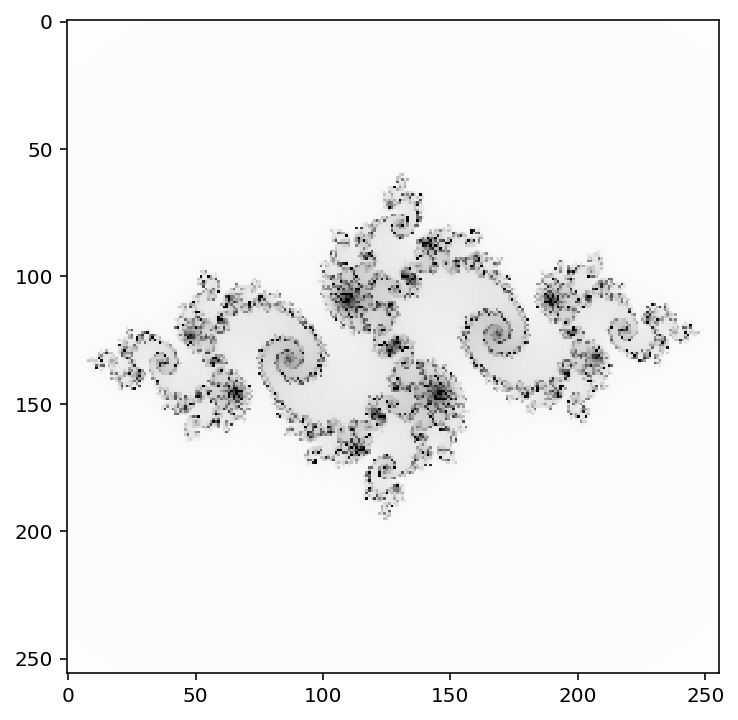

In [230]:
plot_julia_set(juliaset_python(x, y, c, lim, maxit))

# Fortran

In [231]:
%load_ext fortranmagic

The fortranmagic extension is already loaded. To reload it, use:
  %reload_ext fortranmagic


In [234]:
%%fortran
subroutine juliaset_fortran(x, y, c, lim, maxit, julia)

    real(8),    intent(in)  :: x(:)
    real(8),    intent(in)  :: y(:)
    complex(8), intent(in)  :: c
    real(8),    intent(in)  :: lim
    integer,    intent(in)  :: maxit
    integer(4), intent(out) :: julia(size(x),size(y))

    complex(8) :: z
    integer    :: ite, nx, ny

    nx = size(x)
    ny = size(y)

    do i = 1, nx
       do j = 1, ny
            z = cmplx(x(i), y(j))
            ite = 0
            do while (abs(z) < lim .and. ite < maxit)
                z = z*z + c
                ite = ite + 1
            end do
            julia(j, i) = ite
        end do
    end do


end subroutine juliaset_fortran

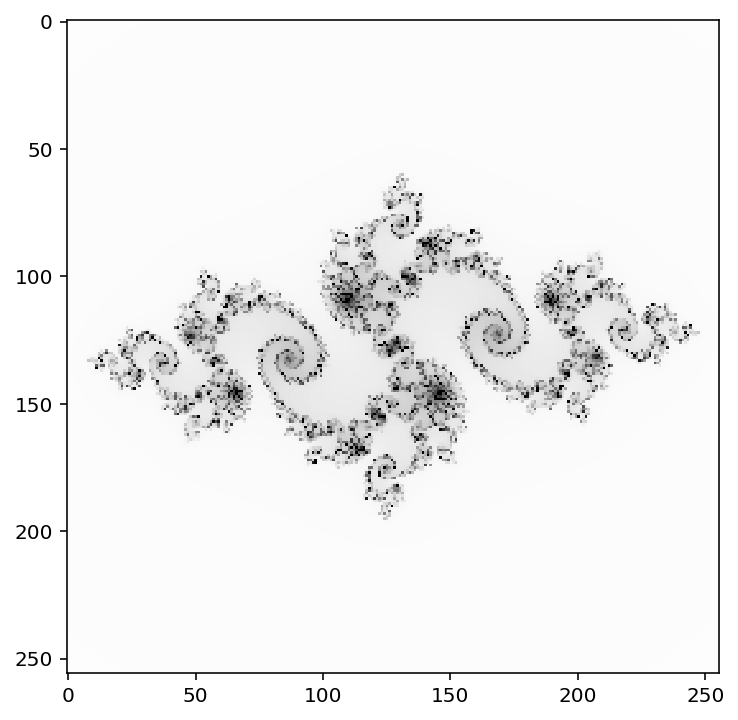

In [235]:
plot_julia_set(juliaset_fortran(x, y, c, lim, maxit))

# Numpy

In [236]:
import itertools

def juliaset_numpy(x, y, c, lim, maxit):
    julia = np.zeros((x.size, y.size), dtype=np.int32)

    zx = x[np.newaxis, :]
    zy = y[:, np.newaxis]
    
    z = zx + zy*1j
    
    for ite in itertools.count():
        
        z = z**2 + c 
        if np.all(julia) or ite > maxit:
            break
        else:
            mask = np.logical_not(julia) & (np.abs(z) >= lim)
            julia[mask] = ite

    return julia

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in absolute
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in square
  del sys.path[0]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater_equal


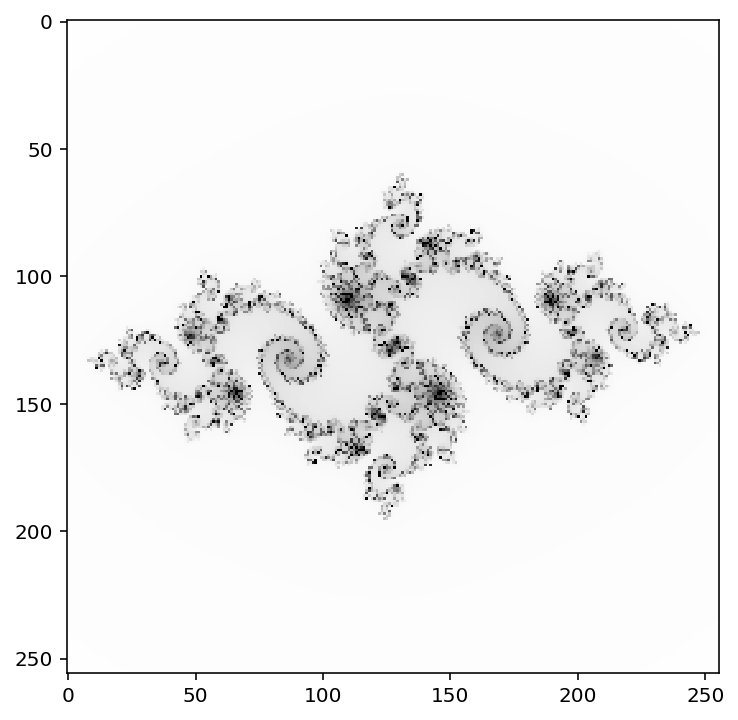

In [237]:
plot_julia_set(juliaset_numpy(x, y, c, lim, maxit))

# Cython

In [238]:
%load_ext cython
%env CC=gcc-8

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
env: CC=gcc-8


In [239]:
%%cython
import numpy as np
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def juliaset_cython(double [:] x, double [:] y, double complex c, double lim, int maxit):
    cdef:
        int [:, ::1] julia = np.zeros((x.size, y.size), dtype = np.int32)
        double tmp, zr, zi, lim2 = lim*lim
        double cr = c.real, ci = c.imag
        int ite, i, j, nx=x.size, ny=y.size

    for i in xrange(nx):
        for j in xrange(ny):
            zr = x[i] 
            zi = y[j]
            ite = 0
            while (zr*zr + zi*zi) < lim2 and ite < maxit:
                zr, zi = zr*zr - zi*zi + cr, 2*zr*zi + ci
                ite += 1
            julia[j, i] = ite

    return julia

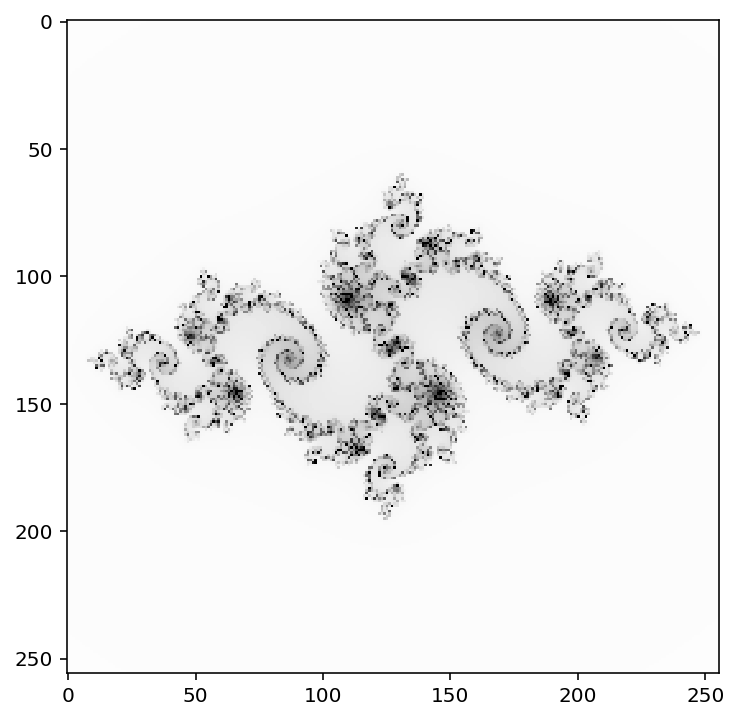

In [240]:
plot_julia_set(juliaset_cython(x, y, c, lim, maxit))

In [ ]:
%%cython -f -c-fopenmp --link-args=-fopenmp
import numpy as np
import cython
from cython.parallel import prange
from libc.stdlib cimport malloc, free 

@cython.boundscheck(False)
@cython.wraparound(False)
def juliaset_cython_omp(double [:] x, double [:] y, double complex c, double lim, int maxit):
    cdef:
        int [:, ::1] julia = np.zeros((x.size, y.size), dtype = np.int32)
        double tmp, zr, zi, lim2 = lim*lim
        double cr = c.real, ci = c.imag
        int  i, j, nx=x.size, ny=y.size
        int *ite

    for j in prange(ny, nogil=True, schedule='dynamic'):
        ite = <int *> malloc(sizeof(int))
        for i in xrange(nx):
            zr = x[i] 
            zi = y[j]
            ite[0] = 0
            while (zr*zr + zi*zi) < lim2 and ite[0] < maxit:
                zr, zi = zr*zr - zi*zi + cr, 2*zr*zi + ci
                ite[0] += 1
            julia[j, i] = ite[0]
        free(ite)
        
    return julia

In [1]:
plot_julia_set(juliaset_cython_omp(x, y, c, lim, maxit))

NameError: name 'plot_julia_set' is not defined

# numba

In [ ]:
from numba import autojit

@autojit
def juliaset_numba(x, y, c, lim, maxit):
    julia = np.zeros((x.size, y.size))
    lim2 = lim*lim
    
    c = complex(c)  # needed for numba
    for i in range(x.size):
        for j in range(y.size):
            z = complex(x[i], y[j])
            ite = 0
            while (z.real*z.real + z.imag*z.imag) < lim2 and ite < maxit:
                z = z*z + c
                ite += 1
            julia[j, i] = ite

    return julia

In [ ]:
plot_julia_set(juliaset_numba(x, y, c, lim, maxit))

In [219]:
import pandas as pd
from collections import defaultdict
results = defaultdict(list)

functions = [juliaset_python, 
                 juliaset_fortran,
                 juliaset_numpy, 
                 juliaset_cython,
                 juliaset_cython_omp, 
                 juliaset_numba]

for f in functions:
    
    _ = %timeit -oq -n 10 f(x, y, c, lim, maxit)
    results['etimes'] += [_.best]
    


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in absolute
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in square
  del sys.path[0]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater_equal


In [220]:
results = pd.DataFrame(results, index=map(lambda f:f.__name__[9:],functions))
results

,etimes
python,1.142694
fortran,0.005874
numpy,0.263776
cython,0.003502
cython_omp,0.001016
numba,0.003721
